In [ ]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from utils import *
from param_estimation import *


In [ ]:
# test grid of reference, can either be 30_ieee, 118_ieee or 300_ieee
name = '30_ieee'

# soft connectivity constraint flag, if false then hard constraint is used
# take one of the examples from the repo
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)


#convert the matrix to a sparse format
G_sparse = ordmat.cpu().numpy()  
n_components = connected_components(csr_matrix(G_sparse))
print("Number of connected components in the graph:", n_components[0])


In [ ]:
two_community = gen_two_community_graph(max_nodes_per_community=30, min_nodes_per_community=29, p_intra=0.5, links=1)
#ordmat = torch.tensor(nx.to_numpy_array(two_community))
plot_graph(ordmat)

In [139]:
#define your sampler obj with your observables

class MySampler(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        #average_degree = torch.sum(mtx, dim=1).mean()
        #avg_clustering = (torch.diagonal(torch.matmul(torch.matmul(mtx,mtx),mtx)/2) / (torch.sum(mtx, dim=1) * (torch.sum(mtx, dim=1) - 1.0))).mean()
        return(torch.stack([edges, triangles, ac]))

betas = torch.tensor([0., 0., 0.], dtype=float)

In [144]:
#parameters to touch if you want to affect convergence
alpha = 0.002
niter = 102
min_change = 0.01
update_steps = 4

#starting point of parameters

sampler = MySampler(backend="cuda")
obs = sampler.observables(ordmat)

# run with parameter estimation
parlist = sampler.param_run(graph=ordmat,
                      observables=obs,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change = min_change)

CUDA backend not available falling back to cpu


  0%|          | 0/102 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:00<00:00, 386.17it/s]

number of accepted steps is:  102
number of rejected samples:  0
number of effective updates is:  25


[-0.0005  -0.00048 -0.0005 ]
(3, 3)


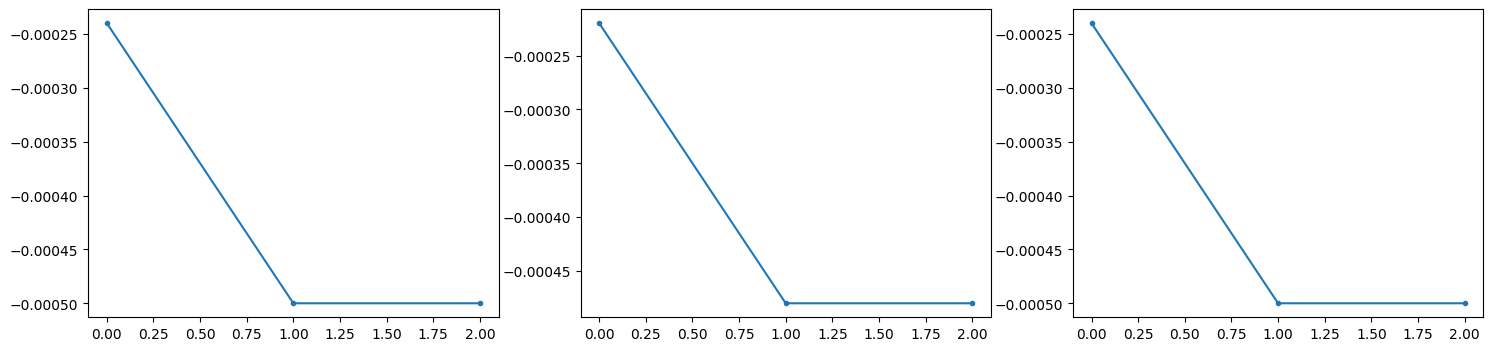

In [145]:
params = [p.cpu().numpy() for p in parlist[0]]
parlist_np = np.array(params)
print(parlist_np[-1])
print(parlist_np.shape)

w = 10
h = 8
scale = 0.6

w = int(w * scale)
h = int(h * scale)

plt.figure(figsize = (parlist_np.shape[1] * w, h))
for p in range(parlist_np.shape[1]):
    plt.subplot(1,parlist_np.shape[1], p + 1)
    plt.plot(parlist_np[:,p], '.-')

In [146]:
params_for_estimates = torch.stack(parlist[0][-100:]).mean(axis = 0)
params_for_estimates

tensor([-0.0004, -0.0004, -0.0004], dtype=torch.float64)

In [147]:
params_for_estimates = torch.stack(parlist[0][-100:-1]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables, graphs = sampler.sample_run(graph=ordmat,
                      observables=obs,
                      params=params_for_estimates,
                      niter=niter,
                      save_every=50)

100%|██████████| 102/102 [00:00<00:00, 386.07it/s]

number of accepted steps is:  102
number of rejected samples:  0
Mean obs:  tensor([92.3333, 38.6667,  1.6946], dtype=torch.float64)


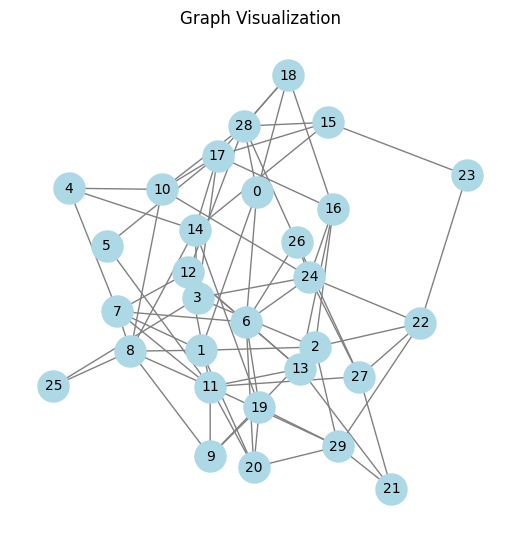

In [148]:
plot_graph(graphs[0])

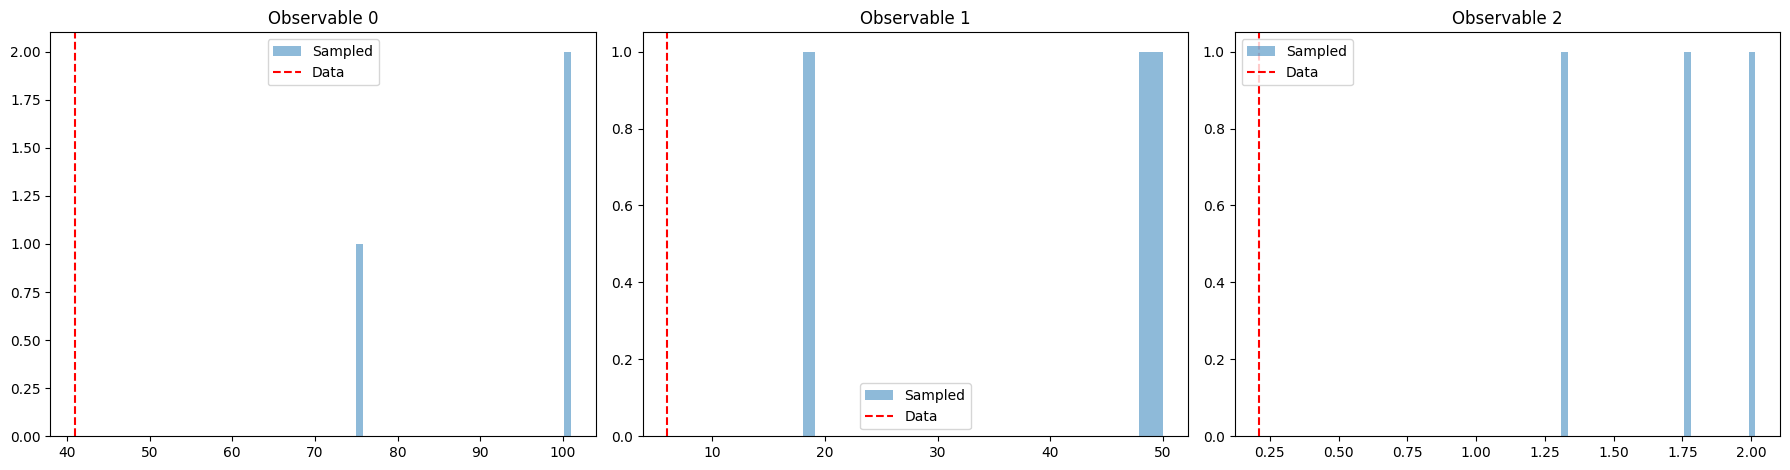

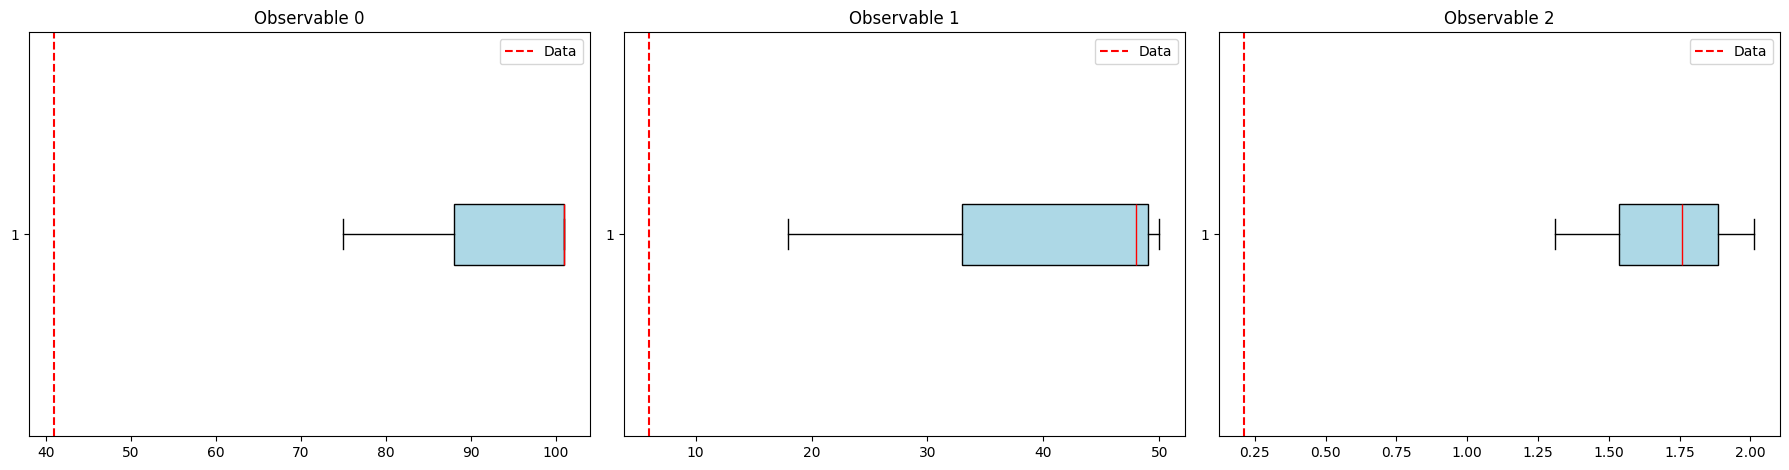

In [149]:
hist_obs_samples(observables, obs)
boxplot_obs_samples(observables, obs)

In [ ]:
not_connected_graphs = sum([1 for gobs in graphs if connected_components(csr_matrix(gobs.cpu().numpy()))[0] > 1])
not_connected_graphs/len(graphs)

In [ ]:
ref = nx.from_numpy_array(ordmat.cpu().numpy())
i = 0
for graph in graphs:
    if nx.is_isomorphic(nx.from_numpy_array(graph.cpu().numpy()), ref): i+=1

i

In [150]:
def mean_difference(sampler, real_graph, generated_samples:list[torch.Tensor]):
    real_obs = sampler.observables(real_graph)
    generated_obs = [sampler.observables(g) for g in generated_samples]

    mean_obs = torch.stack(generated_obs).mean(axis = 0)

    return abs(real_obs-mean_obs)

In [151]:
mean_difference(sampler,ordmat, graphs)

tensor([51.3333, 32.6667,  1.4825], dtype=torch.float64)

---

In [157]:
class MySampler(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        #average_degree = torch.sum(mtx, dim=1).mean()
        #avg_clustering = (torch.diagonal(torch.matmul(torch.matmul(mtx,mtx),mtx)/2) / (torch.sum(mtx, dim=1) * (torch.sum(mtx, dim=1) - 1.0))).mean()
        return(torch.stack([edges, triangles, ac]))

betas = torch.tensor([0., 0., 0.], dtype=float)

sampler = MySampler(backend="cuda")

best = grid_search_params(sampler, ordmat, betas,
                       obs_weight=torch.tensor([0.2, 0.2, 0.6]),
                       alphas=[0.001, 0.1, 0.01],
                       min_changes=[0.01, 0.05],
                       update_steps_list=[2, 4, 8],
                       betas_init_list=None,
                       niter=50000,
                       equilibrium_samples=100,
                       save_every=50)

CUDA backend not available falling back to cpu
Eseguo con (alpha=0.001, min_change=0.01, update_steps=2)


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:33<00:00, 1510.70it/s]


number of accepted steps is:  17987
number of rejected samples:  32013
number of effective updates is:  8993
Parametri stimati: tensor([-2.3098, -0.1084, -0.1728], dtype=torch.float64)


100%|██████████| 50000/50000 [00:25<00:00, 1976.43it/s]


number of accepted steps is:  8982
number of rejected samples:  41018
Mean obs:  tensor([39.2668,  2.6996,  0.0452], dtype=torch.float64)
Numero di grafi generati: 892
[alpha=0.001, min_change=0.01, update_steps=2] → score=0.3690
Eseguo con (alpha=0.001, min_change=0.01, update_steps=4)


100%|██████████| 50000/50000 [00:35<00:00, 1417.76it/s]


number of accepted steps is:  26724
number of rejected samples:  23276
number of effective updates is:  6681
Parametri stimati: tensor([-2.0466, -0.6135, -1.0106], dtype=torch.float64)


100%|██████████| 50000/50000 [00:25<00:00, 1929.13it/s]


number of accepted steps is:  10018
number of rejected samples:  39982
Mean obs:  tensor([44.0882,  2.4706,  0.0670], dtype=torch.float64)
Numero di grafi generati: 1020
[alpha=0.001, min_change=0.01, update_steps=4] → score=0.4702
Eseguo con (alpha=0.001, min_change=0.01, update_steps=8)


100%|██████████| 50000/50000 [00:41<00:00, 1207.03it/s]


number of accepted steps is:  38989
number of rejected samples:  11011
number of effective updates is:  4873
Parametri stimati: tensor([-0.4095, -0.4095, -0.4095], dtype=torch.float64)


100%|██████████| 50000/50000 [00:34<00:00, 1460.94it/s]


number of accepted steps is:  25469
number of rejected samples:  24531
Mean obs:  tensor([110.3087,  48.7963,   2.5523], dtype=torch.float64)
Numero di grafi generati: 962
[alpha=0.001, min_change=0.01, update_steps=8] → score=7.9417
Eseguo con (alpha=0.001, min_change=0.05, update_steps=2)


100%|██████████| 50000/50000 [00:31<00:00, 1563.94it/s]


number of accepted steps is:  15555
number of rejected samples:  34445
number of effective updates is:  7777
Parametri stimati: tensor([-2.2436, -0.0704, -0.1730], dtype=torch.float64)


100%|██████████| 50000/50000 [00:29<00:00, 1677.24it/s]


number of accepted steps is:  9472
number of rejected samples:  40528
Mean obs:  tensor([41.1502,  3.5371,  0.0533], dtype=torch.float64)
Numero di grafi generati: 1052
[alpha=0.001, min_change=0.05, update_steps=2] → score=0.2060
Eseguo con (alpha=0.001, min_change=0.05, update_steps=4)


100%|██████████| 50000/50000 [00:39<00:00, 1275.28it/s]


number of accepted steps is:  21578
number of rejected samples:  28422
number of effective updates is:  5394
Parametri stimati: tensor([-2.1807, -0.3913, -0.8237], dtype=torch.float64)


100%|██████████| 50000/50000 [00:26<00:00, 1909.84it/s]


number of accepted steps is:  9379
number of rejected samples:  40621
Mean obs:  tensor([4.0439e+01, 2.4519e+00, 3.7918e-02], dtype=torch.float64)
Numero di grafi generati: 1049
[alpha=0.001, min_change=0.05, update_steps=4] → score=0.3088
Eseguo con (alpha=0.001, min_change=0.05, update_steps=8)


100%|██████████| 50000/50000 [00:37<00:00, 1340.73it/s]


number of accepted steps is:  31520
number of rejected samples:  18480
number of effective updates is:  3940
Parametri stimati: tensor([-0.8489, -0.8466, -0.8401], dtype=torch.float64)


100%|██████████| 50000/50000 [00:30<00:00, 1657.30it/s]


number of accepted steps is:  18650
number of rejected samples:  31350
Mean obs:  tensor([79.9369, 12.5712,  1.2347], dtype=torch.float64)
Numero di grafi generati: 1061
[alpha=0.001, min_change=0.05, update_steps=8] → score=3.2384
Eseguo con (alpha=0.1, min_change=0.01, update_steps=2)


100%|██████████| 50000/50000 [00:25<00:00, 1976.89it/s]


number of accepted steps is:  120
number of rejected samples:  49880
number of effective updates is:  60
Parametri stimati: tensor([-0.4598, -0.3800, -0.4598], dtype=torch.float64)


100%|██████████| 50000/50000 [00:37<00:00, 1340.26it/s]


number of accepted steps is:  25365
number of rejected samples:  24635
Mean obs:  tensor([108.8605,  47.7128,   2.4831], dtype=torch.float64)
Numero di grafi generati: 982
[alpha=0.1, min_change=0.01, update_steps=2] → score=7.7591
Eseguo con (alpha=0.1, min_change=0.01, update_steps=4)


100%|██████████| 50000/50000 [00:23<00:00, 2109.71it/s]


number of accepted steps is:  224
number of rejected samples:  49776
number of effective updates is:  56
Parametri stimati: tensor([-0.4561, -0.3427, -0.3769], dtype=torch.float64)


100%|██████████| 50000/50000 [00:37<00:00, 1336.12it/s]


number of accepted steps is:  25846
number of rejected samples:  24154
Mean obs:  tensor([112.6259,  55.2333,   2.6674], dtype=torch.float64)
Numero di grafi generati: 973
[alpha=0.1, min_change=0.01, update_steps=4] → score=8.5483
Eseguo con (alpha=0.1, min_change=0.01, update_steps=8)


100%|██████████| 50000/50000 [00:24<00:00, 2033.74it/s]


number of accepted steps is:  432
number of rejected samples:  49568
number of effective updates is:  54
Parametri stimati: tensor([-0.4547, -0.4547, -0.4547], dtype=torch.float64)


100%|██████████| 50000/50000 [00:30<00:00, 1641.13it/s]


number of accepted steps is:  24234
number of rejected samples:  25766
Mean obs:  tensor([106.9142,  43.3663,   2.4595], dtype=torch.float64)
Numero di grafi generati: 1002
[alpha=0.1, min_change=0.01, update_steps=8] → score=7.3348
Eseguo con (alpha=0.1, min_change=0.05, update_steps=2)


100%|██████████| 50000/50000 [00:18<00:00, 2703.40it/s]


number of accepted steps is:  90
number of rejected samples:  49910
number of effective updates is:  45
Parametri stimati: tensor([-0.3176, -0.2625, -0.3176], dtype=torch.float64)


100%|██████████| 50000/50000 [00:43<00:00, 1162.53it/s]


number of accepted steps is:  28900
number of rejected samples:  21100
Mean obs:  tensor([124.5968,  80.1844,   3.1981], dtype=torch.float64)
Numero di grafi generati: 987
[alpha=0.1, min_change=0.05, update_steps=2] → score=11.1159
Eseguo con (alpha=0.1, min_change=0.05, update_steps=4)


100%|██████████| 50000/50000 [00:20<00:00, 2423.67it/s]


number of accepted steps is:  172
number of rejected samples:  49828
number of effective updates is:  43
Parametri stimati: tensor([-0.3056, -0.2779, -0.2526], dtype=torch.float64)


100%|██████████| 50000/50000 [00:34<00:00, 1457.32it/s]


number of accepted steps is:  28827
number of rejected samples:  21173
Mean obs:  tensor([124.8335,  79.4482,   3.2642], dtype=torch.float64)
Numero di grafi generati: 955
[alpha=0.1, min_change=0.05, update_steps=4] → score=11.0959
Eseguo con (alpha=0.1, min_change=0.05, update_steps=8)


100%|██████████| 50000/50000 [00:18<00:00, 2644.97it/s]


number of accepted steps is:  272
number of rejected samples:  49728
number of effective updates is:  34
Parametri stimati: tensor([-0.2092, -0.2092, -0.1178], dtype=torch.float64)


100%|██████████| 50000/50000 [00:36<00:00, 1360.91it/s]


number of accepted steps is:  31522
number of rejected samples:  18478
Mean obs:  tensor([137.8329, 112.5643,   3.9157], dtype=torch.float64)
Numero di grafi generati: 1035
[alpha=0.1, min_change=0.05, update_steps=8] → score=14.3005
Eseguo con (alpha=0.01, min_change=0.01, update_steps=2)


100%|██████████| 50000/50000 [00:26<00:00, 1915.62it/s]


number of accepted steps is:  7596
number of rejected samples:  42404
number of effective updates is:  3798
Parametri stimati: tensor([-3.6302,  1.1929, 61.9105], dtype=torch.float64)


100%|██████████| 50000/50000 [00:16<00:00, 3010.57it/s]


number of accepted steps is:  552
number of rejected samples:  49448
Mean obs:  tensor([ 396.5294, 3561.1412,   25.1327], dtype=torch.float64)
Numero di grafi generati: 170
[alpha=0.01, min_change=0.01, update_steps=2] → score=265.6955
Eseguo con (alpha=0.01, min_change=0.01, update_steps=4)


100%|██████████| 50000/50000 [00:28<00:00, 1728.32it/s]


number of accepted steps is:  10812
number of rejected samples:  39188
number of effective updates is:  2703
Parametri stimati: tensor([-2.8980,  1.1739, 19.2849], dtype=torch.float64)


100%|██████████| 50000/50000 [00:25<00:00, 1941.15it/s]


number of accepted steps is:  508
number of rejected samples:  49492
Mean obs:  tensor([ 327.3860, 2686.3333,   18.9315], dtype=torch.float64)
Numero di grafi generati: 114
[alpha=0.01, min_change=0.01, update_steps=4] → score=201.5252
Eseguo con (alpha=0.01, min_change=0.01, update_steps=8)


100%|██████████| 50000/50000 [00:35<00:00, 1424.76it/s]


number of accepted steps is:  12871
number of rejected samples:  37129
number of effective updates is:  1608
Parametri stimati: tensor([-2.3183,  0.0498,  0.0173], dtype=torch.float64)


100%|██████████| 50000/50000 [00:34<00:00, 1449.84it/s]


number of accepted steps is:  9152
number of rejected samples:  40848
Mean obs:  tensor([4.0104e+01, 3.2006e+00, 2.7565e-02], dtype=torch.float64)
Numero di grafi generati: 982
[alpha=0.01, min_change=0.01, update_steps=8] → score=0.2833
Eseguo con (alpha=0.01, min_change=0.05, update_steps=2)


100%|██████████| 50000/50000 [00:36<00:00, 1354.28it/s]


number of accepted steps is:  4532
number of rejected samples:  45468
number of effective updates is:  2266
Parametri stimati: tensor([-2.5124,  0.7415, 97.1382], dtype=torch.float64)


100%|██████████| 50000/50000 [00:32<00:00, 1559.34it/s]


number of accepted steps is:  464
number of rejected samples:  49536
Mean obs:  tensor([ 307.6000, 1994.2000,   15.5011], dtype=torch.float64)
Numero di grafi generati: 30
[alpha=0.01, min_change=0.05, update_steps=2] → score=153.3778
Eseguo con (alpha=0.01, min_change=0.05, update_steps=4)


100%|██████████| 50000/50000 [00:36<00:00, 1358.49it/s]


number of accepted steps is:  10246
number of rejected samples:  39754
number of effective updates is:  2561
Parametri stimati: tensor([-3.2753,  1.0460, 26.7908], dtype=torch.float64)


100%|██████████| 50000/50000 [00:30<00:00, 1657.20it/s]


number of accepted steps is:  4023
number of rejected samples:  45977
Mean obs:  tensor([1.7995e+01, 7.4393e-01, 3.8612e-04], dtype=torch.float64)
Numero di grafi generati: 988
[alpha=0.01, min_change=0.05, update_steps=4] → score=1.9264
Eseguo con (alpha=0.01, min_change=0.05, update_steps=8)


100%|██████████| 50000/50000 [00:25<00:00, 1941.28it/s]


number of accepted steps is:  11575
number of rejected samples:  38425
number of effective updates is:  1446
Parametri stimati: tensor([-2.3141,  0.4347,  0.6173], dtype=torch.float64)


100%|██████████| 50000/50000 [00:16<00:00, 2980.91it/s]


number of accepted steps is:  10550
number of rejected samples:  39450
Mean obs:  tensor([45.1815,  6.4537,  0.0884], dtype=torch.float64)
Numero di grafi generati: 1047
[alpha=0.01, min_change=0.05, update_steps=8] → score=0.3338


In [159]:
best_params = best["params"]

In [161]:
niter = 100000
observables, graphs = sampler.sample_run(graph=ordmat,
                      observables=obs,
                      params=best_params,
                      niter=niter,
                      save_every=50)

100%|██████████| 100000/100000 [01:02<00:00, 1599.12it/s]

number of accepted steps is:  18811
number of rejected samples:  81189
Mean obs:  tensor([40.8663,  3.3521,  0.0451], dtype=torch.float64)


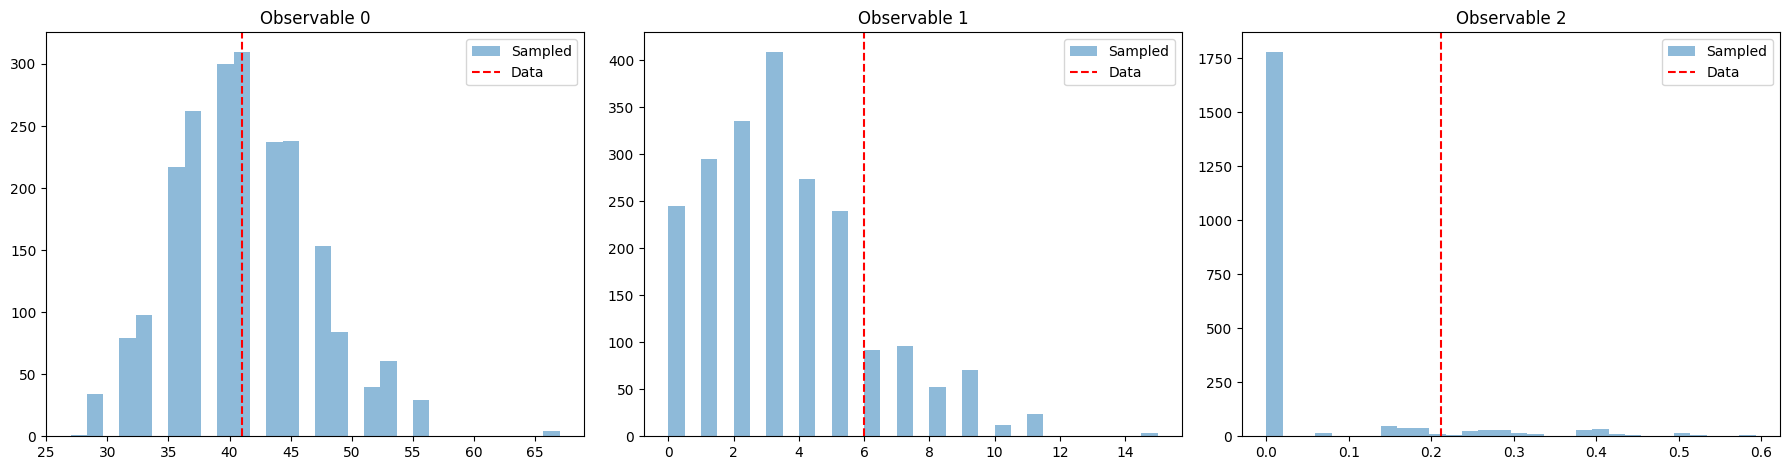

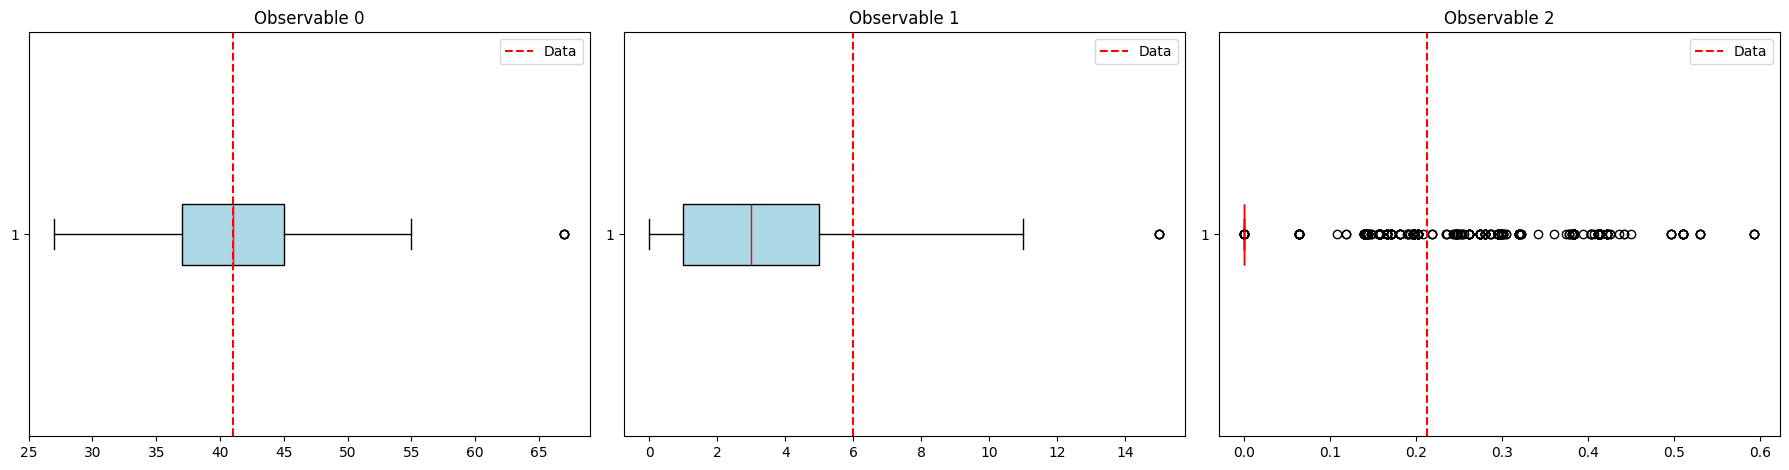

0

In [164]:
hist_obs_samples(observables, obs)
boxplot_obs_samples(observables, obs)

ref = nx.from_numpy_array(ordmat.cpu().numpy())
i = 0
for graph in graphs:
    if nx.is_isomorphic(nx.from_numpy_array(graph.cpu().numpy()), ref): i+=1

i

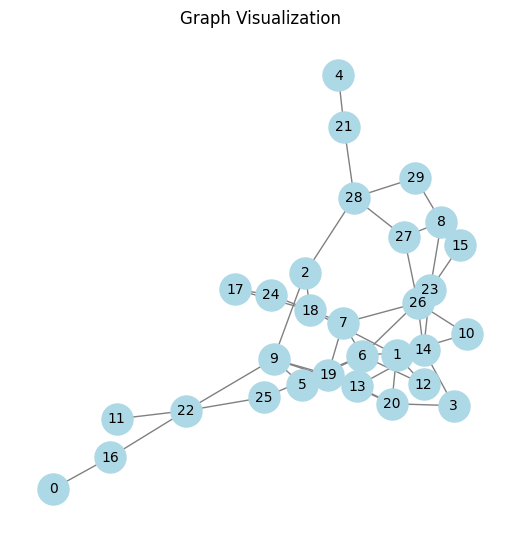

In [ ]:
plot_graph(graphs[-7])